In [2]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
# define parameters
dt = 600              # [sec] temporal resolution of model input in seconds (10min = 600 sec)  
eps_glac = 1;         # [...] emmissivity of glacier surface
Zm = 2                # [m] measurement height of wind
Zh = 2                # [m] measurement height of temperature
Zl = 2                # [m] measurement height of humidity (water vapor pressure)
Z0_m = 0.001          # [m] roughness length for momentum
Z0_h = 0.001          # [m] roughness length for temperature (sensible heat)
Z0_l = 0.001          # [m] roughness length for vapor (latent heat)

# define some constants

sigma = 5.67*10**(-8) # [...]Stefan-Boltzmann constant
cp = 1004;            # [J kg^-1 K^-1]specific heat of air at constant pressure
P0 = 1013.25          # [hPa] mean air pressure at sea level
rho_0 = 1.29          # [kg m^-3] density of air at P0 and T = 273.15K
k = 0.4               # van Karman constant
Lv = 2.5*10**6        # [J kg^-1] latent heat of vaporisation
Lm = 3.34*10**5       # [J kg^-1] latent heat of fusion
Ls = Lv + Lm          # [J kg^-1] latent heat of sublimation
Rv = 461              # [J kg^-1 K^-1] gas constant for water vapor
T0 = 273.15           # [K] tripple point of water 
cw = 4200             # specific heat capacity of water [J kg^-1 K^-1]


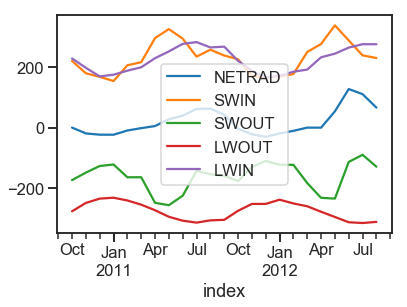

In [36]:
#read the data set
df=pd.read_csv('data_Zhadang_localtime.csv',index_col=0, parse_dates=True)
#Change sign of SWOUT to negative
df['SWOUT']=-df['SWOUT']
#Convert SURFTEMP to LWOut and append to df
SURFTEMP = df['SURFTEMP']
Ts = df['SURFTEMP']+273.15
LWOUT = -sigma*Ts**4
df['LWOUT']=LWOUT
#Create data vectors 
SWIN = df['SWIN']
SWOUT = df['SWOUT']
NETRAD = df['NETRAD']
Rh = df['RH']
Wisp = df['WINDSPEED']
Ta = df['TEMP']+273.15
Pa =df['PRESSURE']

LWIN = NETRAD - SWIN -SWOUT -LWOUT

df['LWIN']=LWIN

#compute monthly averages
monthly_mean_df = df.resample('MS').mean()
monthly_fluxes = monthly_mean_df.drop(columns=['PRESSURE','ANGLE','WINDSPEED','RH','SR50','TEMP','WINDDIR','SURFTEMP','PRCP'])
monthly_fluxes.plot()
#monthly_mean_df['PRCP'].plot()



Net Radiation is positive April-October on average. negative during November-March. Incoming Shortwave radiation appears to peak in late spring in both years and preceeds the peak of net radiation. This may suggest cloudier/wetter conditions during the summer are prevalent which would reduce the shortwave radiation reaching the surface. Outgoing Longwave radiation peaks in July in both years with a minimum in January and fits a very similar pattern to the net radiation. The same is true for incoming longwave radiation. 

In [37]:
#sensible heat


Ts[Ts>273.15]=273.15   

# bulk formula for sensible heat
Qs = cp*rho_0*Pa/P0*k**2*Wisp*(Ta - Ts)/(np.log(Zm/Z0_m)*np.log(Zh/Z0_h));

# LATENT HEAT+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# e... vapor pressure
# E... saturation vapor pressure (function of Temp.)
# a... atmosphere (at measurement level)
# s... (glacier) surface
  
#calculate saturation vapor pressure at measurement level (a) from Magnus Equation
Ea = 6.112*np.exp(Lv/Rv*(1/T0 - 1/Ta)) 
  
#calculate actual vapor pressure at M.L. from relative humidity 
#(with respect to saturation over water -> due to measurement convention)
ea = Rh*Ea/100 
        
#calculate (saturation) vapor pressure at glacier surface (s), 
# use Ls because of ice surface which always is at 0°C or colder (at 0° no difference)
Es = 6.112*np.exp(Ls/Rv*(1/T0 - 1/Ts))
       
# bulk formula for latent heat
Q1 = 0.623*Ls*rho_0/P0*k**2*Wisp*(ea-Es)/(np.log(Zm/Z0_m)*np.log(Zl/Z0_l));

Text(0, 0.5, 'Residual Flux (Wm-1)')

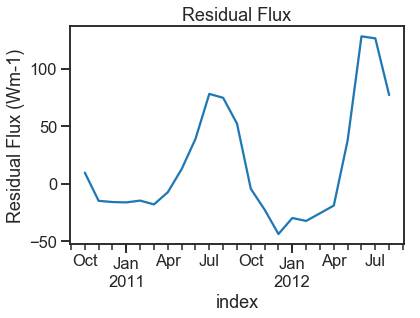

In [51]:
#Exercise 3 - calculate residual flux

F = NETRAD + Qs + Q1
F
df['F']=F
#i) Monthly Average
monthly_mean_F = df['F'].resample('MS').mean()
fig = monthly_mean_F.plot(title = 'Residual Flux')
fig.set_ylabel('Residual Flux (Wm-1)')

Text(0, 0.5, 'Residual Flux(Wm-1))')

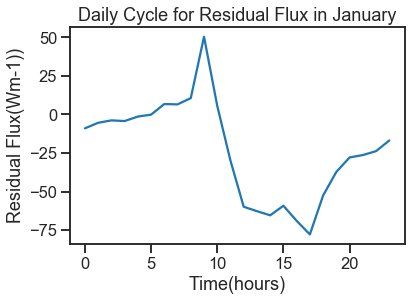

In [52]:
#ii) 
df_jan = df.loc[df.index.month == 1]
df_jan =  df_jan.groupby(df_jan.index.hour).mean()
df_jan_fig = df_jan['F'].plot(title='Daily Cycle for Residual Flux in January')
df_jan_fig.set_xlabel('Time(hours)')
df_jan_fig.set_ylabel('Residual Flux(Wm-1))')

In [ ]:
#For a typical January day F is close to 0 overnight, with a spike in the morning which appears to coincide with sunrise and the initial spike in incoming shortwave radiation. The residual flux rapidly decreases around 10am as outgoing longwave radiation increases and remains negative until sunset when it tends towards 0.

Text(0, 0.5, 'Residual Flux(Wm-1))')

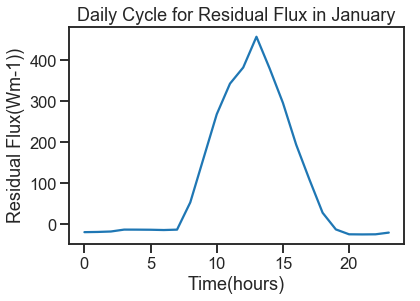

In [55]:
#ii) 
df_jul = df.loc[df.index.month == 7]
df_jul =  df_jul.groupby(df_jul.index.hour).mean()
df_jul_fig = df_jul['F'].plot(title = 'Daily Cycle for Residual Flux in July')
df_jul_fig.set_xlabel('Time(hours)')
df_jul_fig.set_ylabel('Residual Flux(Wm-1))')

In [ ]:
#For July the mean daily cycle is very clear - the energy available for melt spikes around early afternoon when the incoming solar radiation is at its peak and returns to around 0 during the night in the absence of sunlight.A plot of both factors makes it clear that F follows a similar shape to SWIN 

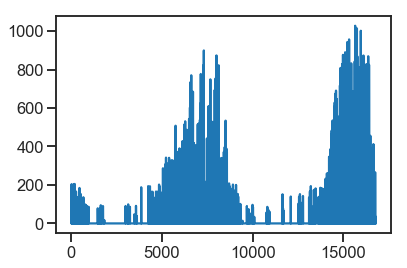

In [41]:
#Over non-ice surface F would be energy available for heating. For F>0 and T=0 F is the energy available for melt, for F<0 T=0 it is energy available for freezing, for T<0 and F>0 it is energy available to heat the surface up to 0C
Qm = F;
#...F is positive and...
Qm = np.where(F>0,F,0)
#the surface temperature is at freezing point
Qm = np.where(Ts == 273.15,Qm,0)
plt.plot(Qm)

In [42]:
#iv) 
#create data frame for fluxes
dflux= df.drop(columns=['PRESSURE','ANGLE','WINDSPEED','RH','SR50','TEMP','WINDDIR','SURFTEMP','PRCP'])
dflux['Qs']=Qs
dflux['Q1']=Q1
dflux['F']=F
#apply conditions used in 3
dflux = dflux.where(dflux['F']>0,0)
dflux = dflux.where(Ts==273.15,0)
#dflux['NETRAD','SWIN','SWOUT','LWOUT','LWIN','F','Qs','Q1'] = np.where(dflux['F']>0,F,0)
#Qs = np.where(Ts == 273.15, Qs, 0)
#dflux['NETRAD']=np.where(dflux['NETRAD','SWIN','SWOUT','LWOUT','LWIN','F','Qs','Q1']>0,F,0)

dflux_mean=dflux.mean()
dflux_mean.nlargest(8)

SWIN      101.217934
LWIN       43.039303
NETRAD     36.666923
F          34.911318
Qs          2.479734
Q1         -4.235339
LWOUT     -47.082516
SWOUT     -60.507798
dtype: float64

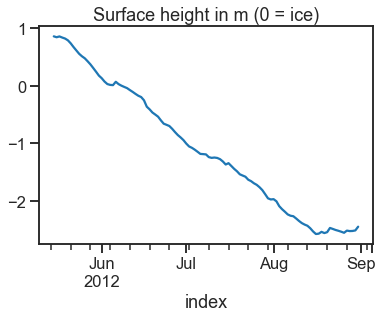

In [69]:
#Exercise 5
# resample 
df = df.resample('D').mean()
df = df.loc['2012-05-15':'2012-08-31']
df['SR50'].plot(title='Surface height in m (0 = ice)');

In [73]:
# select all days with temp above 0
seltemp = df.TEMP.loc[df.TEMP > 0]
# sum it
seltemp.sum()
#Define new variable (average temperature for melt days)
df['PDD'] = np.where(df.TEMP > 0, df.TEMP, 0)
obs_melt = df.SR50.iloc[-1] - df.SR50.iloc[0] 
obs_melt
melt_factor = obs_melt / df['PDD'].sum()
df['MELT1'] = (df['PDD'] * melt_factor).cumsum() + df.SR50.iloc[0]
df['IS_SNOW'] = np.where(df.SR50 > 0, True, False)
# first, compute the PDD sum during the snowmelt period:
pdd_snow = df.PDD.loc[df['IS_SNOW']].sum()
# Then, compute the observed melt during this period. It is simply:
melt_snow = - df.SR50.iloc[0]
# Finally, compute the factor:
fac_snow = melt_snow / pdd_snow
# first, compute the PDD sum during the ice melt period:
pdd_ice = df.PDD.loc[~ df['IS_SNOW']].sum()  # note the ~
# Then, compute the observed melt during this period. It is simply:
melt_ice = df.SR50.iloc[-1]
# Finally, compute the factor:
fac_ice = melt_ice / pdd_ice
fac_ice


-0.010931945060044752

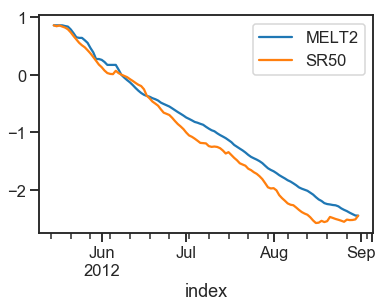

In [74]:
df['MIXED_FAC'] = np.where(df['IS_SNOW'], fac_snow, fac_ice)
df['MELT2'] = (df['PDD'] * df['MIXED_FAC']).cumsum() + df.SR50.iloc[0]
df[['MELT2', 'SR50']].plot();